In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
import warnings

warnings.filterwarnings("ignore")

In [18]:
tickers = ["RELIANCE.NS", "TCS.NS", "HDFCBANK.NS", "INFY.NS", "ICICIBANK.NS", "SBIN.NS"]

In [19]:
def download_with_indicators(symbol):
    try:
        raw = yf.download(symbol, period="1y", interval="1d", progress=False)

        if raw is None or raw.empty:
            print("No data:", symbol)
            return None

        # ---- ALWAYS FLATTEN CLOSE COLUMN ----
        close_raw = raw["Close"]

        # Convert to numpy + flatten to 1-D
        close_1d = np.asarray(close_raw).ravel().astype(float)

        # Rebuild clean dataframe
        df = pd.DataFrame({"Close": close_1d}, index=raw.index)

        # Indicators
        df["RSI"] = ta.momentum.RSIIndicator(df["Close"], window=14).rsi()

        macd = ta.trend.MACD(df["Close"])
        df["MACD"] = macd.macd()
        df["Signal"] = macd.macd_signal()

        df["MA200"] = df["Close"].rolling(200).mean()

        df.dropna(inplace=True)
        return df

    except Exception as e:
        print("Error loading", symbol, ":", e)
        return None

In [20]:
def add_ml_features(df):
    if df is None or len(df) < 50:
        return None  # Not enough data to compute features

    df = df.copy()

    df["Returns"] = df["Close"].pct_change()
    df["Target"] = (df["Returns"].shift(-1) > 0).astype(int)

    df["MA10"] = df["Close"].rolling(10).mean()
    df["MA20"] = df["Close"].rolling(20).mean()
    df["MA50"] = df["Close"].rolling(50).mean()

    df["Volatility"] = df["Returns"].rolling(10).std()

    df.dropna(inplace=True)
    return df

In [21]:
def train_ml(df):
    df = df.copy()

    X = df[["RSI", "MACD", "Signal"]]
    y = (df["Close"].shift(-1) > df["Close"]).astype(int)  # Up/down label

    df.dropna(inplace=True)
    X = X.iloc[:-1]
    y = y.iloc[:-1]

    if len(X) < 3:
        return 0  # Not enough data → ML score = 0

    # Dynamic splits
    n_splits = max(2, min(5, len(X) - 1))
    tscv = TimeSeriesSplit(n_splits=n_splits)

    acc_scores = []
    for train, test in tscv.split(X):
        model = LGBMClassifier()
        model.fit(X.iloc[train], y.iloc[train])
        preds = model.predict(X.iloc[test])
        acc = accuracy_score(y.iloc[test], preds)
        acc_scores.append(acc)

    return np.mean(acc_scores)

In [22]:
def backtest(df):
    if df is None or df.empty:
        return None

    df = df.copy()

    df["Signal_Buy"] = (
        (df["RSI"] < 30) & (df["MACD"] > df["Signal"]) & (df["Close"] > df["MA200"])
    )

    df["Strategy_Return"] = df["Returns"] * df["Signal_Buy"].shift(1)

    df.dropna(inplace=True)

    if df.empty:
        return None

    return df["Strategy_Return"].cumsum() * 100

In [23]:
results = []

for symbol in tickers:
    print("Processing:", symbol)
    df = download_with_indicators(symbol)
    if df is None:
        continue

    df = add_ml_features(df)

    ml_score = train_ml(df)

    # Get latest values safely
    rsi = df["RSI"].iloc[-1]
    macd = df["MACD"].iloc[-1]
    signal = df["Signal"].iloc[-1]
    price = df["Close"].iloc[-1]
    ma200 = df["MA200"].iloc[-1]

    buy_signal = (rsi < 30) and (macd > signal) and (price > ma200)
    sell_signal = (rsi > 70) and (macd < signal) and (price < ma200)

    results.append(
        {
            "Symbol": symbol,
            "RSI": rsi,
            "MACD > Signal": macd > signal,
            "Price > MA200": price > ma200,
            "BUY?": buy_signal,
            "SELL?": sell_signal,
            "ML Score": round(ml_score, 3),
        }
    )
    print(df)


results_df = pd.DataFrame(results)
results_df

Processing: RELIANCE.NS
                  Close        RSI       MACD     Signal        MA200  \
Date                                                                    
2025-11-19  1518.900024  69.193415  25.668462  25.306701  1372.935889   
2025-11-20  1549.099976  75.672730  27.476842  25.740729  1374.441062   
2025-11-21  1546.599976  74.279972  28.381108  26.268805  1375.873725   

             Returns  Target         MA10         MA20         MA50  \
Date                                                                  
2025-11-19 -0.000329       1  1505.470020  1491.785004  1430.986011   
2025-11-20  0.019883       0  1510.770020  1496.820001  1434.444011   
2025-11-21 -0.001614       0  1517.630017  1501.570001  1437.836011   

            Volatility  
Date                    
2025-11-19    0.007720  
2025-11-20    0.008561  
2025-11-21    0.006921  
Processing: TCS.NS
                  Close        RSI       MACD     Signal        MA200  \
Date                                 

,Symbol,RSI,MACD > Signal,Price > MA200,BUY?,SELL?,ML Score
0,RELIANCE.NS,74.279972,True,True,False,False,0
1,TCS.NS,63.380112,True,False,False,False,0
2,HDFCBANK.NS,55.090538,True,True,False,False,0
3,INFY.NS,59.997902,True,True,False,False,0
4,ICICIBANK.NS,49.769566,True,False,False,False,0
5,SBIN.NS,69.711531,False,True,False,False,0


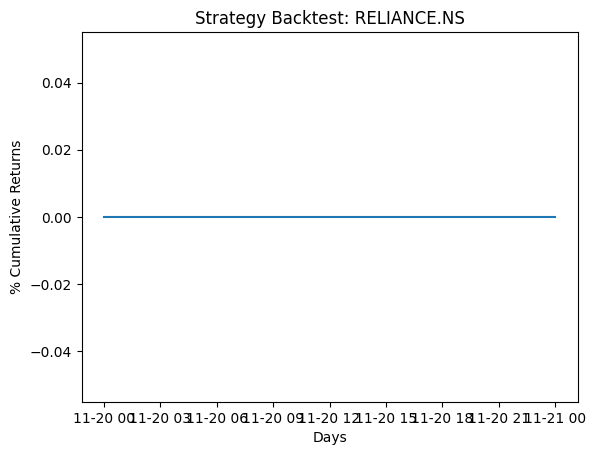

In [24]:
sym = tickers[0]
df = download_with_indicators(sym)
if df is None:
    print("Skipping:", sym, "(failed download)")


df = add_ml_features(df)
if df is None:
    print("Skipping:", sym, "(not enough data after indicators)")


cum_ret = backtest(df)

plt.plot(cum_ret)
plt.title(f"Strategy Backtest: {sym}")
plt.xlabel("Days")
plt.ylabel("% Cumulative Returns")
plt.show()